# Diffusion coefficient from a VASP file

[Previously](./vasp_msd.html), we looked at obtaining accurate estimates for the mean-squared displacement with `kinisi`. 
Here, we show that the same `DiffusionAnalyzer` can be used to evaluate the diffusion coefficient, using the `kinisi` [methodology](./methodology.html).

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipp as sc
from pymatgen.io.vasp import Xdatcar
from kinisi.analyze import DiffusionAnalyzer
rng = np.random.RandomState(42)

As wil the [previous example](./vasp_msd.html), `params` dictionary will describe the details about the simulation.

In [2]:
params = {'specie': 'Li',
          'time_step': 2.0 * sc.Unit('fs'),
          'step_skip': 50 * sc.Unit('dimensionless'),
          'progress': False
          }

In this example, we will add an additional key-value pair to the dictionary. 
This argument means that the diffusion coefficient will only be calculated in the *xy* plane of the simulation box. 

In [3]:
params['dimension']= 'xy'

As with the previous example, we now use the `from_xdatcar` class method to construct the `DiffusionAnalyzer` object. 

In [4]:
xd = Xdatcar('./example_XDATCAR.gz')
diff = DiffusionAnalyzer.from_xdatcar(xd, **params)

In the above cells, we parse and determine the uncertainty on the mean-squared displacement as a function of the timestep. 
We should visualise this, to check that we are observing diffusion in our material and to determine the timescale at which this diffusion begins. 

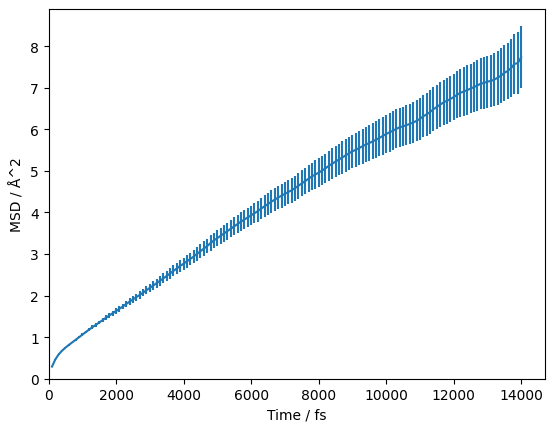

In [5]:
fig, ax = plt.subplots()

ax.errorbar(diff.dt.values, diff.msd.values, np.sqrt(diff.msd.variances))
ax.set_xlabel(f'Time / {diff.dt.unit}')
ax.set_ylabel(f'MSD / {diff.msd.unit}')
ax.set_xlim(0, None)
ax.set_ylim(0, None)
plt.show()

We can visualise this on a log-log scale, which helps to reveal the diffusive regime (the region where the gradient stops changing).

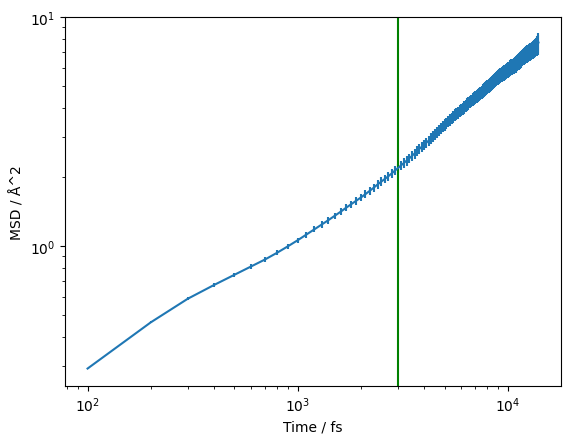

In [6]:
fig, ax = plt.subplots()

ax.errorbar(diff.dt.values, diff.msd.values, np.sqrt(diff.msd.variances))
ax.axvline(3000, color='g')
ax.set_xlabel(f'Time / {diff.dt.unit}')
ax.set_ylabel(f'MSD / {diff.msd.unit}')
ax.set_xscale('log')
ax.set_yscale('log')
plt.show()

The green line at 3000 fs appears to be a reasonable estimate of the start of the diffusive regime. 
Therefore, we want to pass `3000 * sc.Units('fs')` as the argument to the diffusion analysis below. 
At this stage, we pass the `random_state` argument to ensure reproducibility. 

In [7]:
start_of_diffusion = 3000 * sc.Unit('fs')
diff.diffusion(start_of_diffusion, progress=False, random_state=rng)

This method estimates the correlation matrix between the timesteps and uses posterior sampling to find the self-diffusion coefficient, $D*$ and intercept.
We can find the mean of the marginal posterior samples of $D*$: 

In [8]:
diff.D

<scipp.Variable> (samples: 3200)    float64         [cm^2/s]  [1.20905e-05, 1.13378e-05, ..., 1.08981e-05, 1.33307e-05]

The same for the intercept can be found from `diff.intercept`. 
A histogram of the marginal posterior probability distribution for $D*$ can be plotted as shown below. 

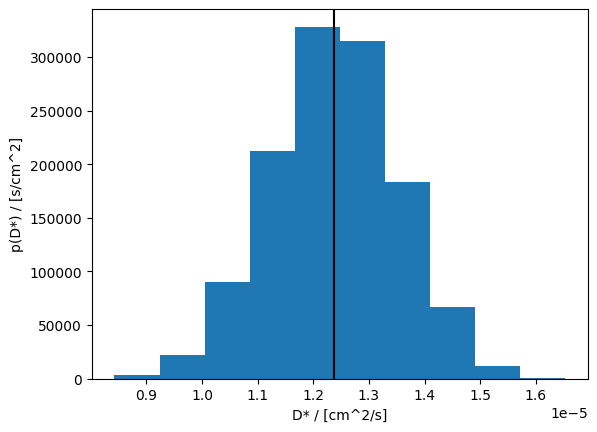

In [9]:
fig, ax = plt.subplots()

ax.hist(diff.D.values, density=True)
ax.axvline(sc.mean(diff.D).value, c='k')
ax.set_xlabel(f'D* / [{diff.D.unit}]')
ax.set_ylabel(f'p(D*) / [{(1 / diff.D.unit).unit}]')
plt.show()


It is also possible to plot the posterior distribution of the models on the data. 
We represent this distribution with 1σ-, 2σ-, and 3σ-credible intervals. 
Here we remove the measured error bars, in the interest of clarity.

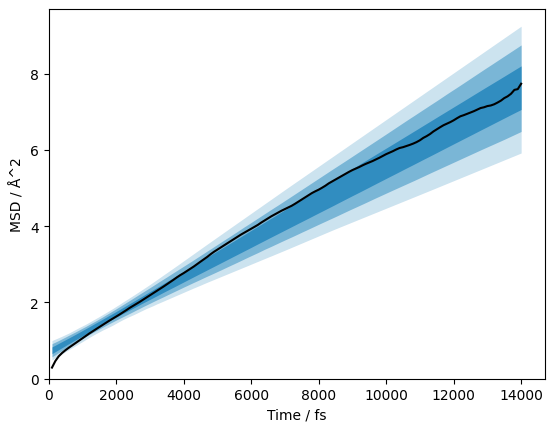

In [10]:
credible_intervals = [[16, 84], [2.5, 97.5], [0.15, 99.85]]
alpha = [0.6, 0.4, 0.2]

fig, ax = plt.subplots()
ax.plot(diff.dt.values, diff.msd.values, 'k-')
for i, ci in enumerate(credible_intervals):
    ax.fill_between(diff.dt.values,
                      *np.percentile(diff.distributions, ci, axis=1),
                      alpha=alpha[i],
                      color='#0173B2',
                      lw=0)
ax.set_xlabel(f'Time / {diff.dt.unit}')
ax.set_ylabel(f'MSD / {diff.msd.unit}')
ax.set_xlim(0, None)
ax.set_ylim(0, None)
plt.show()

Finally, the joint posterior probability distribution for the diffusion coefficient and intercept can be visualised with the `corner` library. 

In [11]:
from corner import corner

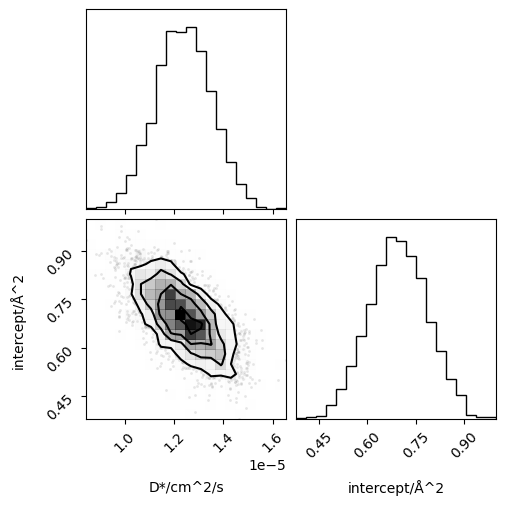

In [12]:
corner(np.array([i.values for i in diff.flatchain.values()]).T, 
       labels=['/'.join([k, str(v.unit)]) for k, v in diff.flatchain.items()])
plt.show()